# Bu proje, 2024-2025 Güz Dönemi Yapay Zekâ Teknikleri Dersi Final Sınavı için hazırlanmıştır.
# Proje Konusu: Sosyal Medya Duygu Analizi
# Seçilen Sosyal Medya Platformu: Uludağ Sözlük




In [2]:
# Gerekli kütüphane velerin import edilme işlemi bu hücrede gerçekleştirilmektedir:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from nltk.corpus import stopwords
from tensorflow.keras.models import load_model

# Stopwords yükleme işlemi (Türkçe stopwords için):
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('turkish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Yüklenen dosyaları okuma işlemi:
train_data = pd.read_excel("train_tweets.xlsx")
test_data = pd.read_excel("test_tweets.xlsx")

# İlk birkaç satırın incelenmesi:
print("Train Data:")
print(train_data.head())

print("\nTest Data:")
print(test_data.head())

Train Data:
  Ulan Wifi'ye bağlıyım ben. Ona bağlıyken Turkcell internet paketin bitti diye nasıl mesaj atabilir bana ya? Onu da mı ödeyelim  \
0  20 dk 1 GB internet 500 mb sadece kaşar turkce...                                                                               
1  Ayrıca turkcell superonline reklamı kadar da k...                                                                               
2                             Turkcell çok pahalı ya                                                                               
3                Turkcell Kaş'ta internetin cekmiyor                                                                               
4  Turkcell'in Allah belası versin demek isterdim...                                                                               

   olumsuz  
0  olumsuz  
1  olumsuz  
2  olumsuz  
3  olumsuz  
4  olumsuz  

Test Data:
  Turkcell'e kızgınım. Ve bu kızgınlık sanırım ayrılıkla sonlanıcak gibi geliyor bana.Farklı bir operatör

In [4]:
# Veri setinin genel bilgilerini görüntülemek için:
print("Train Data Info:")
print(train_data.info())
print("\nTest Data Info:")
print(test_data.info())

# Eksik değer kontrolü aşaması:
print("\nEksik değer kontrolü:")
print(train_data.isnull().sum())
print(test_data.isnull().sum())

# Alınan çıktı neticesinde bu veri setinde eksik değer bulunmadığı tespit edilmiştir.

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13831 entries, 0 to 13830
Data columns (total 2 columns):
 #   Column                                                                                                                          Non-Null Count  Dtype 
---  ------                                                                                                                          --------------  ----- 
 0   Ulan Wifi'ye bağlıyım ben. Ona bağlıyken Turkcell internet paketin bitti diye nasıl mesaj atabilir bana ya? Onu da mı ödeyelim  13831 non-null  object
 1   olumsuz                                                                                                                         13831 non-null  object
dtypes: object(2)
memory usage: 216.2+ KB
None

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3456 entries, 0 to 3455
Data columns (total 2 columns):
 #   Column                                                                      

In [5]:
# Sütun adlarını düzenleme aşaması:
train_data.columns = ['metin', 'etiket']
test_data.columns = ['metin', 'etiket']

# Düzenleme sonrası kontrol etmek için:
print("Train Data:")
print(train_data.head())
print("\nTest Data:")
print(test_data.head())

Train Data:
                                               metin   etiket
0  20 dk 1 GB internet 500 mb sadece kaşar turkce...  olumsuz
1  Ayrıca turkcell superonline reklamı kadar da k...  olumsuz
2                             Turkcell çok pahalı ya  olumsuz
3                Turkcell Kaş'ta internetin cekmiyor  olumsuz
4  Turkcell'in Allah belası versin demek isterdim...  olumsuz

Test Data:
                                               metin   etiket
0                 turkcell kadar şerefsiz misiniz ya  olumsuz
1  Burdan Turkcell'e sesleniyorum o 3 tl haram olsun  olumsuz
2  Hayatımda turkcell kadar kazık 1 operatör görm...  olumsuz
3  Turkcell gözümde son demlerini yaşıyor hattı d...  olumsuz
4            Sonra turkcell olduğunu görüp sövüyorum  olumsuz


In [6]:
# Metin temizleme fonksiyonu:
def temizle(metin):
    metin = metin.lower()  # Küçük harfe çevirme fonksiyonu
    metin = re.sub(r'[^\w\s]', '', metin)  # Noktalama işaretlerini kaldırmak için
    metin = re.sub(r'\d+', '', metin)  # Sayıları kaldırmak için
    metin = re.sub(r'\s+', ' ', metin).strip()  # Fazla boşlukları kaldırmak için
    return metin

# Eğitim ve test verisindeki metinlerin temizlenmesi işlemi:
train_data['metin'] = train_data['metin'].apply(temizle)
test_data['metin'] = test_data['metin'].apply(temizle)

# Temizlemeden sonra ilk birkaç satırı incelemek için:
print("Temizlenmiş Train Data:")
print(train_data.head())

print("\nTemizlenmiş Test Data:")
print(test_data.head())

Temizlenmiş Train Data:
                                               metin   etiket
0  dk gb internet mb sadece kaşar turkcell de düş...  olumsuz
1  ayrıca turkcell superonline reklamı kadar da k...  olumsuz
2                             turkcell çok pahalı ya  olumsuz
3                 turkcell kaşta internetin cekmiyor  olumsuz
4  turkcellin allah belası versin demek isterdim ...  olumsuz

Temizlenmiş Test Data:
                                               metin   etiket
0                 turkcell kadar şerefsiz misiniz ya  olumsuz
1     burdan turkcelle sesleniyorum o tl haram olsun  olumsuz
2   hayatımda turkcell kadar kazık operatör görmedim  olumsuz
3  turkcell gözümde son demlerini yaşıyor hattı d...  olumsuz
4            sonra turkcell olduğunu görüp sövüyorum  olumsuz


Eğitim Verisi Etiket Dağılımı:
etiket
olumsuz    5510
notr       4658
olumlu     3663
Name: count, dtype: int64

Test Verisi Etiket Dağılımı:
etiket
olumsuz    1376
notr       1164
olumlu      916
Name: count, dtype: int64
Eğitim Verisi Etiket Dağılımı:
etiket
olumsuz    5510
notr       4658
olumlu     3663
Name: count, dtype: int64

Test Verisi Etiket Dağılımı:
etiket
olumsuz    1376
notr       1164
olumlu      916
Name: count, dtype: int64


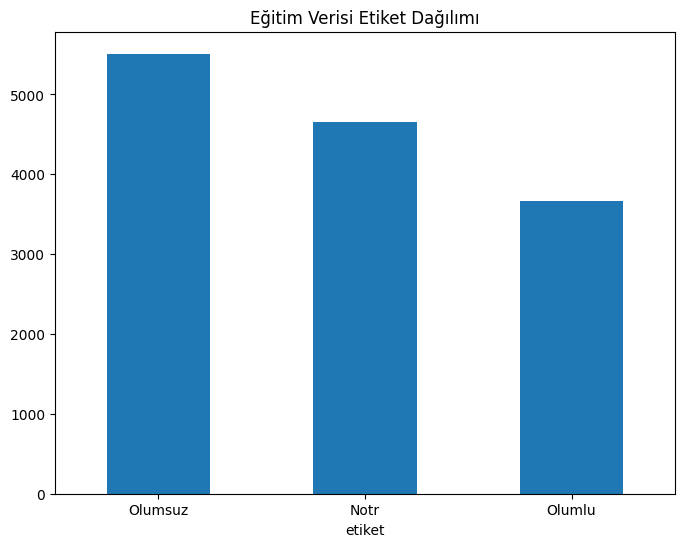

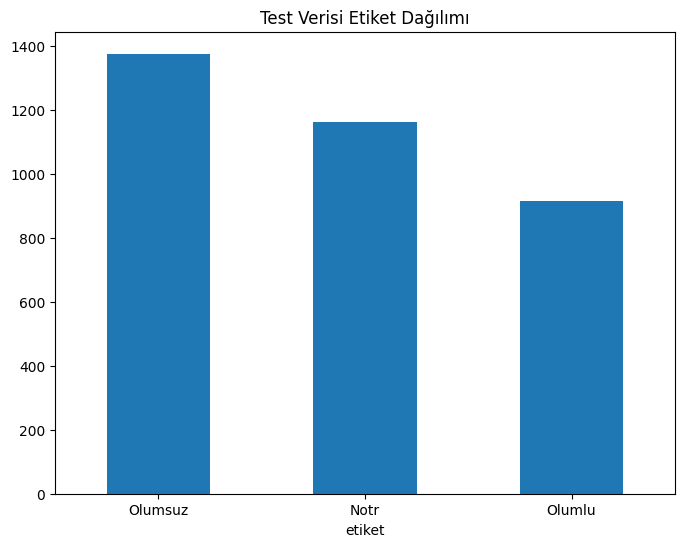

In [7]:
# Etiketlerin dağılımını kontrol etmek ve görselleştirmek için:

print("Eğitim Verisi Etiket Dağılımı:")
print(train_data['etiket'].value_counts())

print("\nTest Verisi Etiket Dağılımı:")
print(test_data['etiket'].value_counts())

print("Eğitim Verisi Etiket Dağılımı:")
print(train_data['etiket'].value_counts())

print("\nTest Verisi Etiket Dağılımı:")
print(test_data['etiket'].value_counts())

# Eğitim verisinin etiket dağılımını görselleştirme:
plt.figure(figsize=(8, 6))
train_data['etiket'].value_counts().plot(kind='bar')
plt.title('Eğitim Verisi Etiket Dağılımı')
plt.xticks(ticks=[0, 1, 2], labels=['Olumsuz', 'Notr', 'Olumlu'], rotation=0)
plt.show()

# Test verisinin etiket dağılımını görselleştirme:
plt.figure(figsize=(8, 6))
test_data['etiket'].value_counts().plot(kind='bar')
plt.title('Test Verisi Etiket Dağılımı')
plt.xticks(ticks=[0, 1, 2], labels=['Olumsuz', 'Notr', 'Olumlu'], rotation=0)
plt.show()

In [8]:
# Etiketleri sayısallaştırma işlemi:
etiket_mapping = {'olumsuz': 0, 'notr': 1, 'olumlu': 2}
train_data['etiket'] = train_data['etiket'].map(etiket_mapping)
test_data['etiket'] = test_data['etiket'].map(etiket_mapping)

# İlk birkaç satırın kontrolü:
print("Sayısallaştırılmış Train Data:")
print(train_data.head())

print("\nSayısallaştırılmış Test Data:")
print(test_data.head())


# Veri setinde başlangıçta sadece olumsuz yorum girdileri yer aldığı için ilk beş sütun değerleri bu şekilde (0) çıkmıştır.

Sayısallaştırılmış Train Data:
                                               metin  etiket
0  dk gb internet mb sadece kaşar turkcell de düş...       0
1  ayrıca turkcell superonline reklamı kadar da k...       0
2                             turkcell çok pahalı ya       0
3                 turkcell kaşta internetin cekmiyor       0
4  turkcellin allah belası versin demek isterdim ...       0

Sayısallaştırılmış Test Data:
                                               metin  etiket
0                 turkcell kadar şerefsiz misiniz ya       0
1     burdan turkcelle sesleniyorum o tl haram olsun       0
2   hayatımda turkcell kadar kazık operatör görmedim       0
3  turkcell gözümde son demlerini yaşıyor hattı d...       0
4            sonra turkcell olduğunu görüp sövüyorum       0


In [9]:
# Tokenizer oluşturma işlemi:
max_num_words = 10000  # Sözlükteki maksimum kelime sayısı
max_sequence_length = 50  # Metinlerin maksimum uzunluğu

tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(train_data['metin'])  # Eğitim verisiyle tokenizer eğitme işlemi

# Metinleri sekanslara dönüştürmek için:
train_sequences = tokenizer.texts_to_sequences(train_data['metin'])
test_sequences = tokenizer.texts_to_sequences(test_data['metin'])

# Sekansları padding ile eşitlemek için:
X_train = pad_sequences(train_sequences, maxlen=max_sequence_length)
X_test = pad_sequences(test_sequences, maxlen=max_sequence_length)

# Etiketleri ayırmak için:
y_train = train_data['etiket'].values
y_test = test_data['etiket'].values

# Veri şekillerinin kontrolü aşaması:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (13831, 50)
X_test shape: (3456, 50)
y_train shape: (13831,)
y_test shape: (3456,)


In [10]:
# Model oluşturmak için:
model = Sequential()

# Embedding katmanı
embedding_dim = 100
model.add(Embedding(input_dim=max_num_words,
                    output_dim=embedding_dim,
                    input_length=max_sequence_length))

# LSTM katmanı:
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))

# Dense katman:
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.6))  # Dropout oranı artırıldı

# Çıkış katmanı:
model.add(Dense(3, activation='softmax'))

# Öğrenme oranı:
optimizer = Adam(learning_rate=0.0001)

# Modeli derleme aşaması:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Modelin özetini yazdırmak için:
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Callback'ler:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Modeli eğitmek için:
epochs = 20
batch_size = 32

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 28s 58ms/step - accuracy: 0.3779 - loss: 1.0940 - val_accuracy: 0.4204 - val_loss: 1.0784 - learning_rate: 1.0000e-04
Epoch 2/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - accuracy: 0.4393 - loss: 1.0663 - val_accuracy: 0.4959 - val_loss: 1.0126 - learning_rate: 1.0000e-04
Epoch 3/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 26s 59ms/step - accuracy: 0.5341 - loss: 0.9801 - val_accuracy: 0.5799 - val_loss: 0.9133 - learning_rate: 1.0000e-04
Epoch 4/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 42s 61ms/step - accuracy: 0.6197 - loss: 0.8514 - val_accuracy: 0.6461 - val_loss: 0.8468 - learning_rate: 1.0000e-04
Epoch 5/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 39s 57ms/step - accuracy: 0.6866 - loss: 0.7594 - val_accuracy: 0.6638 - val_loss: 0.7952 - learning_rate: 1.0000e-04
Epoch 6/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 24s 55ms/step - accuracy: 0.7453 - loss: 0.6583 - val_accuracy: 0.6794 - val_loss: 0.7788 - learning_rate: 1.0000e-04
Epoch 7/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/ste

In [12]:
# Test verisiyle değerlendirme aşaması:
loss, accuracy = model.evaluate(X_test, y_test)

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7292 - loss: 0.6854


# Yukarıdaki kod hücrelerinin çalıştırılması neticesinde model doğruluk oranı **0.7292** olarak görülmektedir. Aşağıdaki kod hücrelerinde model doğruluk değerinin artırılması hedeflenmiştir.

In [13]:
# Stop words kaldırma işlemi:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])

train_data['metin'] = train_data['metin'].apply(remove_stopwords)
test_data['metin'] = test_data['metin'].apply(remove_stopwords)

In [14]:
# Modeli tekrar tanımlama:
model = Sequential()

# Embedding katmanı:
model.add(Embedding(input_dim=max_num_words,
                    output_dim=embedding_dim,
                    input_length=max_sequence_length))

# LSTM katmanları ekleme:
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4, return_sequences=True))
model.add(LSTM(64, dropout=0.4, recurrent_dropout=0.4))

# Dense katman
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.6))  # Dropout oranı artırıldı.

# Çıkış katmanı:
model.add(Dense(3, activation='softmax'))

# Modeli derleme:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Modelin özeti:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,088,840 (7.97 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,088,840 (7.97 MB)

In [15]:
# Yeni optimizer tanımlama işlemi:
optimizer = Adam(learning_rate=0.001)

# Modeli derleme:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [16]:
# Modeli eğitme süreci:

# Callback'ler
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Modeli eğitme
history = model.fit(X_train, y_train,
                    epochs=30,      # Daha fazla epoch eklendi
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 58s 246ms/step - accuracy: 0.3984 - loss: 1.0778 - val_accuracy: 0.5373 - val_loss: 0.9027 - learning_rate: 0.0010
Epoch 2/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 50s 230ms/step - accuracy: 0.6368 - loss: 0.8210 - val_accuracy: 0.6765 - val_loss: 0.7634 - learning_rate: 0.0010
Epoch 3/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 54s 247ms/step - accuracy: 0.7796 - loss: 0.6008 - val_accuracy: 0.6641 - val_loss: 0.7911 - learning_rate: 0.0010
Epoch 4/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 83s 251ms/step - accuracy: 0.8314 - loss: 0.4848 - val_accuracy: 0.6730 - val_loss: 0.8534 - learning_rate: 0.0010
Epoch 5/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 81s 246ms/step - accuracy: 0.8610 - loss: 0.4048 - val_accuracy: 0.6632 - val_loss: 0.9868 - learning_rate: 0.0010
Epoch 6/30
217/217 ━━━━━━━━━━━━━━━━━━━━ 82s 248ms/step - accuracy: 0.8922 - loss: 0.3200 - val_accuracy: 0.6571 - val_loss: 1.1195 - learning_rate: 5.0000e-04


In [17]:
# Test verisiyle değerlendirme
print("\n")
loss, accuracy = model.evaluate(X_test, y_test)



108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.7491 - loss: 0.6496


In [18]:
# Modeli kaydetme
model.save('202113709024_Edanur_AKTAN_FS_model.h5')

# Yapılan bazı değişiklikler sonucu model doğruluk değeri **0.7491**'e yükselmiştir. Model dosyası bu şekilde kaydedilmiştir.

In [19]:
# Kaydedilen model ve tokenizer'ı yüklemek için:
model = load_model('202113709024_Edanur_AKTAN_FS_model.h5')

# Tokenizer dosyasını yüklemek için:
import pickle

# Tokenizer'ı kaydetme işlemi:
with open('202113709024_Edanur_AKTAN_FS_tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
!pip install gradio
!pip install tensorflow
!pip install requests
!pip install beautifulsoup4

# **Aşağıdaki kod hücresi, "Web Scraping" aracılığıyla girdileri çekilen Uludağ Sözlük sitesindeki entry'lerin duygu analizleriyle birlikte görüntülenmesini içerir. Entry konusunu kullanıcı girebilmekte ve istediği konuyla ilgili entry'leri görüntüleyebilmektedir:**

In [22]:
import gradio as gr
import requests
from bs4 import BeautifulSoup
import pickle

# Modeli ve Tokenizer'ı yüklemek için:
model = load_model('202113709024_Edanur_AKTAN_FS_model.h5')

# Tokenizer dosyasını yüklemek için:
with open('202113709024_Edanur_AKTAN_FS_tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Metni temizleme fonksiyonu:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Linkleri kaldır
    text = re.sub(r'@\w+', '', text)    # Mentionları kaldır
    text = re.sub(r'#', '', text)       # Hashtag işaretlerini kaldır
    text = re.sub(r'[^\w\s]', '', text) # Noktalama işaretlerini kaldır
    text = text.lower()                 # Küçük harfe çevir
    return text

# Duygu analizi fonksiyonu:
def predict_sentiment(texts):
    texts = [clean_text(text) for text in texts]
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=50)
    predictions = model.predict(padded_sequences)
    sentiments = ['Olumsuz', 'Nötr', 'Olumlu']
    return [sentiments[np.argmax(pred)] for pred in predictions]

# Web scraping işlemi:
def fetch_entries(keyword):
    url = f"https://www.uludagsozluk.com/k/{keyword}/"
    response = requests.get(url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        entries = soup.find_all('div', class_='entry-body')
        return [entry.get_text(strip=True) for entry in entries]
    else:
        return []

# Gradio arayüzü için fonksiyon:
def scrape_and_analyze(keyword):
    entries = fetch_entries(keyword)

    if not entries:
        return "Hiç entry bulunamadı. Lütfen farklı bir anahtar kelime deneyin."

    # Entry'lerin duygu analizini yapmak için:
    sentiments = predict_sentiment(entries)

    results = []
    for entry, sentiment in zip(entries, sentiments):
        results.append(f"{entry}\n**Duygu:** {sentiment}")

    return "\n\n".join(results)

# Gradio arayüzü oluşturmak için:
iface = gr.Interface(fn=scrape_and_analyze, inputs="text", outputs="text", live=True)

# Arayüzü çalıştırma:
iface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4c2f9a0a7ebd5b0153.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
